In [55]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [56]:
print(tf.__version__)

2.12.0


## Text Classification

### Download and explore the Stack Overflow dataset

In [57]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", 
                                  url, 
                                  untar = True,
                                  cache_dir = ".",
                                  cache_subdir = "")

In [58]:
! mkdir stack_overflow

mkdir: cannot create directory ‘stack_overflow’: File exists


In [59]:
! mv train stack_overflow

mv: cannot move 'train' to 'stack_overflow/train': Directory not empty


In [60]:
! mv test stack_overflow

mv: cannot move 'test' to 'stack_overflow/test': Directory not empty


In [61]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow')

In [62]:
os.listdir(dataset_dir)

['train', 'test']

In [63]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['csharp', 'python', 'javascript', 'java']

In [64]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
  print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

### Load the dataset

In [65]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "stack_overflow/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "training",
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [66]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [67]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.

In [68]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "stack_overflow/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "validation",
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [69]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "stack_overflow/test",
    batch_size = batch_size
)

Found 8000 files belonging to 4 classes.


Note: To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization layer can be included directly inside your model, as shown later in this tutorial.

In [70]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)

  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")

  return tf.strings.regex_replace(stripped_html,
                                  "[%s]" % re.escape(string.punctuation),
                                  "")

In [71]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens = max_features,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [72]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [73]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [74]:
# retrieve a batch (of 32 questions and labels) from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_ques, first_label = text_batch[0], label_batch[0]

print("Question:", first_ques)
print("Label:", raw_train_ds.class_names[first_label])
print("Vectorized question:", vectorize_text(first_ques, first_label))

Question: tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of e

In [75]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])
print(f"Vocaublary size: {len(vectorize_layer.get_vocabulary())}")

1287 --->  scissors
313 --->  source
Vocaublary size: 10000


In [76]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

In [77]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Create the model

In [78]:
embedding_dim = 16

In [79]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])

In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

### Loss function and optimizer



In [81]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = "adam",
              metrics = ["accuracy"])

In [82]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

### Train the model

In [83]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks = [callback]
)

Epoch 1/20
200/200 [==============================] - 3s 11ms/step - loss: 1.3794 - accuracy: 0.3419 - val_loss: 1.3690 - val_accuracy: 0.5063
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 1.3512 - accuracy: 0.4605 - val_loss: 1.3292 - val_accuracy: 0.5256
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 1.2986 - accuracy: 0.5283 - val_loss: 1.2680 - val_accuracy: 0.5681
Epoch 4/20
200/200 [==============================] - 2s 9ms/step - loss: 1.2281 - accuracy: 0.5823 - val_loss: 1.1949 - val_accuracy: 0.6275
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 1.1487 - accuracy: 0.6378 - val_loss: 1.1175 - val_accuracy: 0.6687
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 1.0718 - accuracy: 0.6762 - val_loss: 1.0446 - val_accuracy: 0.6981
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 1.0006 - accuracy: 0.7066 - val_loss: 0.9792 - val_accuracy: 0.7169
Epoc

### Evaluate the model

Let us see how the model performs on the test set.

In [84]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.6371 - accuracy: 0.7818
Loss:  0.6371386051177979
Accuracy:  0.7817500233650208


### Create a plot of accuracy and loss over time

In [85]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

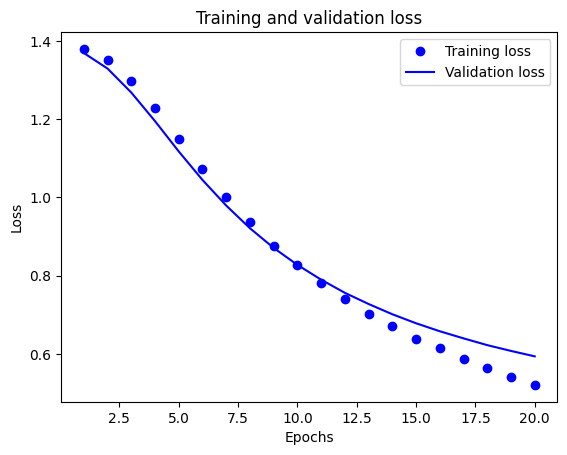

In [86]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = "Training loss")

# "b" is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = "Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show();

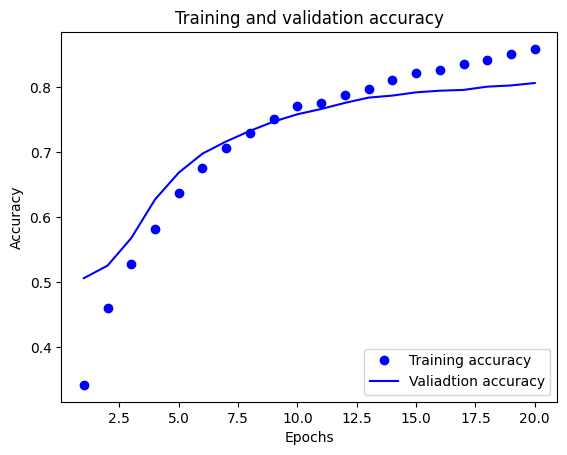

In [87]:
plt.plot(epochs, acc, 'bo', label = "Training accuracy")
plt.plot(epochs, val_acc, 'b', label = "Valiadtion accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show();

### Export the model

In [88]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('softmax')
])

export_model.compile(
   loss = tf.keras.losses.SparseCategoricalCrossentropy(),
          optimizer = "adam",
          metrics = ["accuracy"]
)

# Test it with raw test dataset which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 8ms/step - loss: 0.6371 - accuracy: 0.7818
0.7817500233650208


### Inference on new data

In [89]:
examples = [
    "Why am I getting a FileNotFoundError? [duplicate]",
    "How do you open text files in python3? [duplicate]"
]

export_model.predict(examples)

1/1 [==============================] - 0s 166ms/step


array([[0.26998016, 0.2324009 , 0.30936834, 0.18825053],
       [0.30113173, 0.19686696, 0.25867224, 0.24332903]], dtype=float32)

### Save the model

In [90]:
pip install pyyaml h5py # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
export_model

In [93]:
export_model.save('my_model', save_format = "tf")

### Load the model

In [94]:
new_model = tf.keras.models.load_model("my_model")

new_model

In [95]:
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 250)              0         
 ectorization)                                                   
                                                                 
 sequential_3 (Sequential)   (None, 4)                 160084    
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [97]:
examples = [
    "Why am I getting a FileNotFoundError? [duplicate]",
    "How do you open text files in python3? [duplicate]"
]

new_model.predict(examples)

1/1 [==============================] - 0s 176ms/step


array([[0.26998016, 0.2324009 , 0.30936834, 0.18825053],
       [0.30113173, 0.19686696, 0.25867224, 0.24332903]], dtype=float32)